# Used libraries

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import collections

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [23]:
x_train = pd.read_csv('../x_train.csv', index_col='ID')
y_train = pd.read_csv('../y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('../x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


# Nettoyage

In [24]:
train_cl = train.copy()
test_cl = test.copy()

In [25]:
ret=[f'RET_{k}' for k in range(20,0,-1)]
vol=[f'VOLUME_{k}' for k in range(20,0,-1)]
features = ret+vol
target = 'RET'

In [26]:
for ret_t,vol_t in zip(ret,vol):
        med_ret = train[ret_t].median()
        med_vol = train[vol_t].median()

        train_cl[ret_t] = train_cl[ret_t].fillna(med_ret)
        train_cl[vol_t] = train_cl[vol_t].fillna(med_vol)
        test_cl[ret_t] = test_cl[ret_t].fillna(med_ret)
        test_cl[vol_t] = test_cl[vol_t].fillna(med_vol)

In [27]:
scaler = StandardScaler()
train_cl[ret+vol] = scaler.fit_transform(train_cl[ret+vol])
test_cl[ret+vol] = scaler.fit_transform(test_cl[ret+vol])

# Clustering

In [28]:
k = 50
modele_cluster = MiniBatchKMeans(k,random_state=5).fit(train_cl[features])

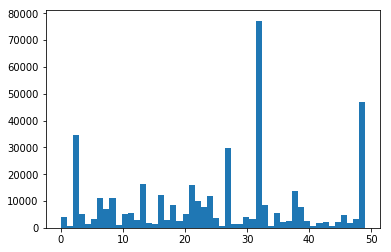

In [29]:
plt.hist(modele_cluster.labels_,bins=k)
plt.show()

In [30]:
train_labeled = train_cl.copy()
train_labeled['Cluster'] = pd.Series(modele_cluster.labels_, index=train_cl.index)
train_labeled.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET,Cluster
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.548528,0.090283,-0.533177,0.118511,...,0.051323,-0.135573,0.244455,-0.000564,-0.398502,0.138649,-0.064255,0.043723,True,20
1,0,3,43,15,6,104,0.083457,-0.063826,-2.963138,-0.070691,...,0.067715,-0.086993,-0.628631,-0.077655,-0.916412,-0.082599,-1.047144,-0.069618,True,4
2,0,4,57,20,8,142,-0.030039,0.002868,-1.937627,0.079476,...,-0.606677,-0.122602,-0.245831,-0.184690,-0.370398,-0.120999,-0.206441,-0.079834,False,2
3,0,8,1,1,1,2,0.958277,-0.116420,0.219650,0.007251,...,1.015320,-0.089423,-0.082767,-0.249749,-0.416874,-0.221775,-1.108181,-0.209274,False,27
4,0,14,36,12,5,92,0.829348,-0.265902,-1.303425,-0.345468,...,-0.450459,0.132584,0.099901,0.041347,0.165120,0.336801,-1.231082,0.366227,False,3


# Sélection des clusters à conserver

In [31]:
frac = 0.67 #Partie du dataset sur lequel appliquer des modèles spécifiques
N = len(train_cl)
clust_desc = pd.Series(collections.Counter(modele_cluster.labels_)).sort_values(ascending=False)
i = 0
C = 0
model_labels = []
while C<N*frac:
    model_labels.append(clust_desc.index[i])
    C+=clust_desc.iloc[i]
    i+=1
model_labels

[32, 49, 2, 27, 13, 21, 38, 16, 24, 6, 8]

# Entraînement des modèles

In [32]:
models = {}

for cluster in model_labels:
    x_train_cl = train_labeled[features][train_labeled['Cluster']==cluster]
    y_train_cl = train_labeled[target][train_labeled['Cluster']==cluster]
    
    rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
    }
    
    model = RandomForestClassifier(**rf_params)
    model.fit(x_train_cl, y_train_cl)
    models[cluster] = model
    
    train_labeled = train_labeled[train_labeled['Cluster']!=cluster] #On supprime du df les data déjà utilisées

#A la fin il reste uniquement les data sans modèle spécifique
x_train_cl = train_labeled[features]
y_train_cl = train_labeled[target]
rf_params = {
'n_estimators': 500,
'max_depth': 2**3,
'random_state': 0,
'n_jobs': -1
}

model = RandomForestClassifier(**rf_params)
model.fit(x_train_cl, y_train_cl)
models['general'] = model

# Préparation du test set

In [33]:
test_labeled = test_cl.copy()
test_labeled['Cluster'] = modele_cluster.predict(test_labeled[features])

# Prédictions

In [34]:
y_pred = pd.Series()

for cluster in model_labels:
    x_test = test_labeled.loc[test_labeled['Cluster']==cluster,features]
    index = x_test.index
    model = models[cluster]
    y_pred = pd.concat([y_pred,pd.Series(model.predict(x_test),index=x_test.index)])
    
    test_labeled = test_labeled[test_labeled['Cluster']!=cluster] #On vire les données utilisées
    
#Il ne reste que les données à traiter avec le modèle général
x_test = test_labeled[features]
index = x_test.index
model = models['general']
y_pred = pd.concat([y_pred,pd.Series(model.predict(x_test),index=x_test.index)])

y_pred = y_pred[test_cl.index]

In [35]:
y_pred.name = target
# y_pred.to_csv('./sub1121F.csv', index=True, header=True)